# IMPORTS

In [1]:
# Parameters 

provider = 'CDS'
GCM = 'DWD'
stage_in = "processed"
period = "hindcasts"
var_name = "T2M"

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt 
import proplot as plot

In [3]:
import os
import sys 
import pathlib

In [4]:
import numpy as np 
import pandas as pd 

In [5]:
import xarray as xr

### ML 

In [6]:
import sklearn
from sklearn.metrics import mean_squared_error as MSE

In [7]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

In [8]:
if not tf.test.is_gpu_available():
    print("No GPU was detected")

### random seeds for reproducibility 

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

### data loading 

In [10]:
HOME = pathlib.Path.home()

In [11]:
local = True 

In [12]:
if local: 
    dirin = pathlib.Path('research/Smart_Ideas')
else: 
    dirin = pathlib.Path('drives/auck_projects/END19101/Working')

In [13]:
ipath = HOME / dirin / 'data' / 'GCMs' / stage_in / period / provider / GCM / var_name

In [14]:
ipath

PosixPath('/home/nicolasf/research/Smart_Ideas/data/GCMs/processed/hindcasts/CDS/DWD/T2M')

### loading the forecasts 

In [15]:
lfiles_nc = list(ipath.glob(f"{GCM}_{var_name}_seasonal_anomalies_interp_????_??.nc"))

In [16]:
len(lfiles_nc)

288

In [17]:
lfiles_nc.sort()

### opens the dataset 

In [18]:
dset = xr.open_mfdataset(lfiles_nc, combine='nested', concat_dim='time')

In [19]:
dset

<xarray.Dataset>
Dimensions:     (lat: 73, lon: 144, member: 30, step: 3, time: 288)
Coordinates:
    surface     int64 0
  * step        (step) int64 3 4 5
  * member      (member) int64 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28 29
  * lat         (lat) float64 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
    valid_time  (time, step) datetime64[ns] dask.array<chunksize=(1, 3), meta=np.ndarray>
Data variables:
    t2m         (time, member, step, lat, lon) float64 dask.array<chunksize=(1, 30, 3, 73, 144), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

### only select step 3, and restrict geographical coverage 

In [20]:
dset = dset.sel(step=3, lat=slice(-65, 65), lon=slice(90, 220))

In [21]:
nx, ny = len(dset.lon), len(dset.lat)

In [22]:
nx, ny

(53, 53)

### calculates the ensemble mean 

In [23]:
dset = dset.mean('member')

In [24]:
dset

<xarray.Dataset>
Dimensions:     (lat: 53, lon: 53, time: 288)
Coordinates:
    surface     int64 0
    step        int64 3
  * lat         (lat) float64 -65.0 -62.5 -60.0 -57.5 ... 57.5 60.0 62.5 65.0
  * lon         (lon) float64 90.0 92.5 95.0 97.5 ... 212.5 215.0 217.5 220.0
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
    valid_time  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    t2m         (time, lat, lon) float64 dask.array<chunksize=(1, 53, 53), meta=np.ndarray>

### load in memory 

In [25]:
dset.compute()

<xarray.Dataset>
Dimensions:     (lat: 53, lon: 53, time: 288)
Coordinates:
    surface     int64 0
    step        int64 3
  * lat         (lat) float64 -65.0 -62.5 -60.0 -57.5 ... 57.5 60.0 62.5 65.0
  * lon         (lon) float64 90.0 92.5 95.0 97.5 ... 212.5 215.0 217.5 220.0
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
    valid_time  (time) datetime64[ns] 1993-05-01 1993-06-01 ... 2017-04-01
Data variables:
    t2m         (time, lat, lon) float64 0.1702 0.2047 0.2736 ... 0.7505 0.818

In [26]:
dset.load()

<xarray.Dataset>
Dimensions:     (lat: 53, lon: 53, time: 288)
Coordinates:
    surface     int64 0
    step        int64 3
  * lat         (lat) float64 -65.0 -62.5 -60.0 -57.5 ... 57.5 60.0 62.5 65.0
  * lon         (lon) float64 90.0 92.5 95.0 97.5 ... 212.5 215.0 217.5 220.0
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
    valid_time  (time) datetime64[ns] 1993-05-01 1993-06-01 ... 2017-04-01
Data variables:
    t2m         (time, lat, lon) float64 0.1702 0.2047 0.2736 ... 0.7505 0.818

In [27]:
dset_train = dset.sel(time=slice(None, '2010'))

In [28]:
dset_valid = dset.sel(time=slice('2011', None))

In [29]:
dset_train.dims

Frozen(SortedKeysDict({'lat': 53, 'lon': 53, 'time': 216}))

In [30]:
dset_valid.dims

Frozen(SortedKeysDict({'lat': 53, 'lon': 53, 'time': 72}))

In [31]:
X_train = dset_train[var_name.lower()].data.astype(np.float32)

In [32]:
X_valid = dset_valid[var_name.lower()].data.astype(np.float32)

### defines the number of encodings here 

In [33]:
n_codings = 20

### selects the activation function 

In [34]:
activation_function = 'selu'

In [35]:
optimizer = 'adam'

### defines the encoder 

In [36]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[ny, nx]),
    keras.layers.Dense(100, activation=activation_function),
    keras.layers.Dense(n_codings, activation=activation_function),
])

### defines the decoder 

In [37]:
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation=activation_function, input_shape=[n_codings]),
    keras.layers.Dense(ny * nx),
    keras.layers.Reshape([ny, nx])
])

In [38]:
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

In [39]:
stacked_ae.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mae','mse'])

In [40]:
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=[X_valid, X_valid])

Train on 216 samples, validate on 72 samples
Epoch 1/20
216/216 [==============================] - 1s 4ms/sample - loss: 0.2483 - mae: 0.3644 - mse: 0.2483 - val_loss: 0.2591 - val_mae: 0.3767 - val_mse: 0.2591
Epoch 2/20
216/216 [==============================] - 0s 149us/sample - loss: 0.1843 - mae: 0.3092 - mse: 0.1843 - val_loss: 0.2121 - val_mae: 0.3382 - val_mse: 0.2121
Epoch 3/20
216/216 [==============================] - 0s 139us/sample - loss: 0.1412 - mae: 0.2710 - mse: 0.1412 - val_loss: 0.1810 - val_mae: 0.3116 - val_mse: 0.1810
Epoch 4/20
216/216 [==============================] - 0s 150us/sample - loss: 0.1181 - mae: 0.2482 - mse: 0.1181 - val_loss: 0.1653 - val_mae: 0.2979 - val_mse: 0.1653
Epoch 5/20
216/216 [==============================] - 0s 142us/sample - loss: 0.1036 - mae: 0.2328 - mse: 0.1036 - val_loss: 0.1530 - val_mae: 0.2869 - val_mse: 0.1530
Epoch 6/20
216/216 [==============================] - 0s 142us/sample - loss: 0.0919 - mae: 0.2196 - mse: 0.0919 - va

In [41]:
last_mse = history.history['val_mse'][-1]

In [42]:
last_mae = history.history['val_mae'][-1]

### look at the codings 

In [43]:
codings = stacked_encoder.predict(X_valid)

In [44]:
reconstructions = stacked_ae.predict(X_valid)

In [45]:
codings.shape

(72, 20)

In [46]:
reconstructions.shape

(72, 53, 53)

### add the reconstructions to the dset_valid dataset 

In [47]:
dset_valid[var_name.lower() + '_recons'] = (('time','lat','lon'), reconstructions)

In [48]:
dset_valid

<xarray.Dataset>
Dimensions:     (lat: 53, lon: 53, time: 72)
Coordinates:
    surface     int64 0
    step        int64 3
  * lat         (lat) float64 -65.0 -62.5 -60.0 -57.5 ... 57.5 60.0 62.5 65.0
  * lon         (lon) float64 90.0 92.5 95.0 97.5 ... 212.5 215.0 217.5 220.0
  * time        (time) datetime64[ns] 2011-01-01 2011-02-01 ... 2016-12-01
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
    valid_time  (time) datetime64[ns] 2011-05-01 2011-06-01 ... 2017-04-01
Data variables:
    t2m         (time, lat, lon) float64 0.3599 0.4714 0.5659 ... 0.7505 0.818
    t2m_recons  (time, lat, lon) float32 0.3455241 0.40939397 ... 0.44529048

In [54]:
i = 0

In [55]:
np.round(last_mae, 2)

0.24

Text(0.5, 1.0, 'reconstruction with stacked AE\n20 codings\nMAE = 0.24, MSE = 0.11')

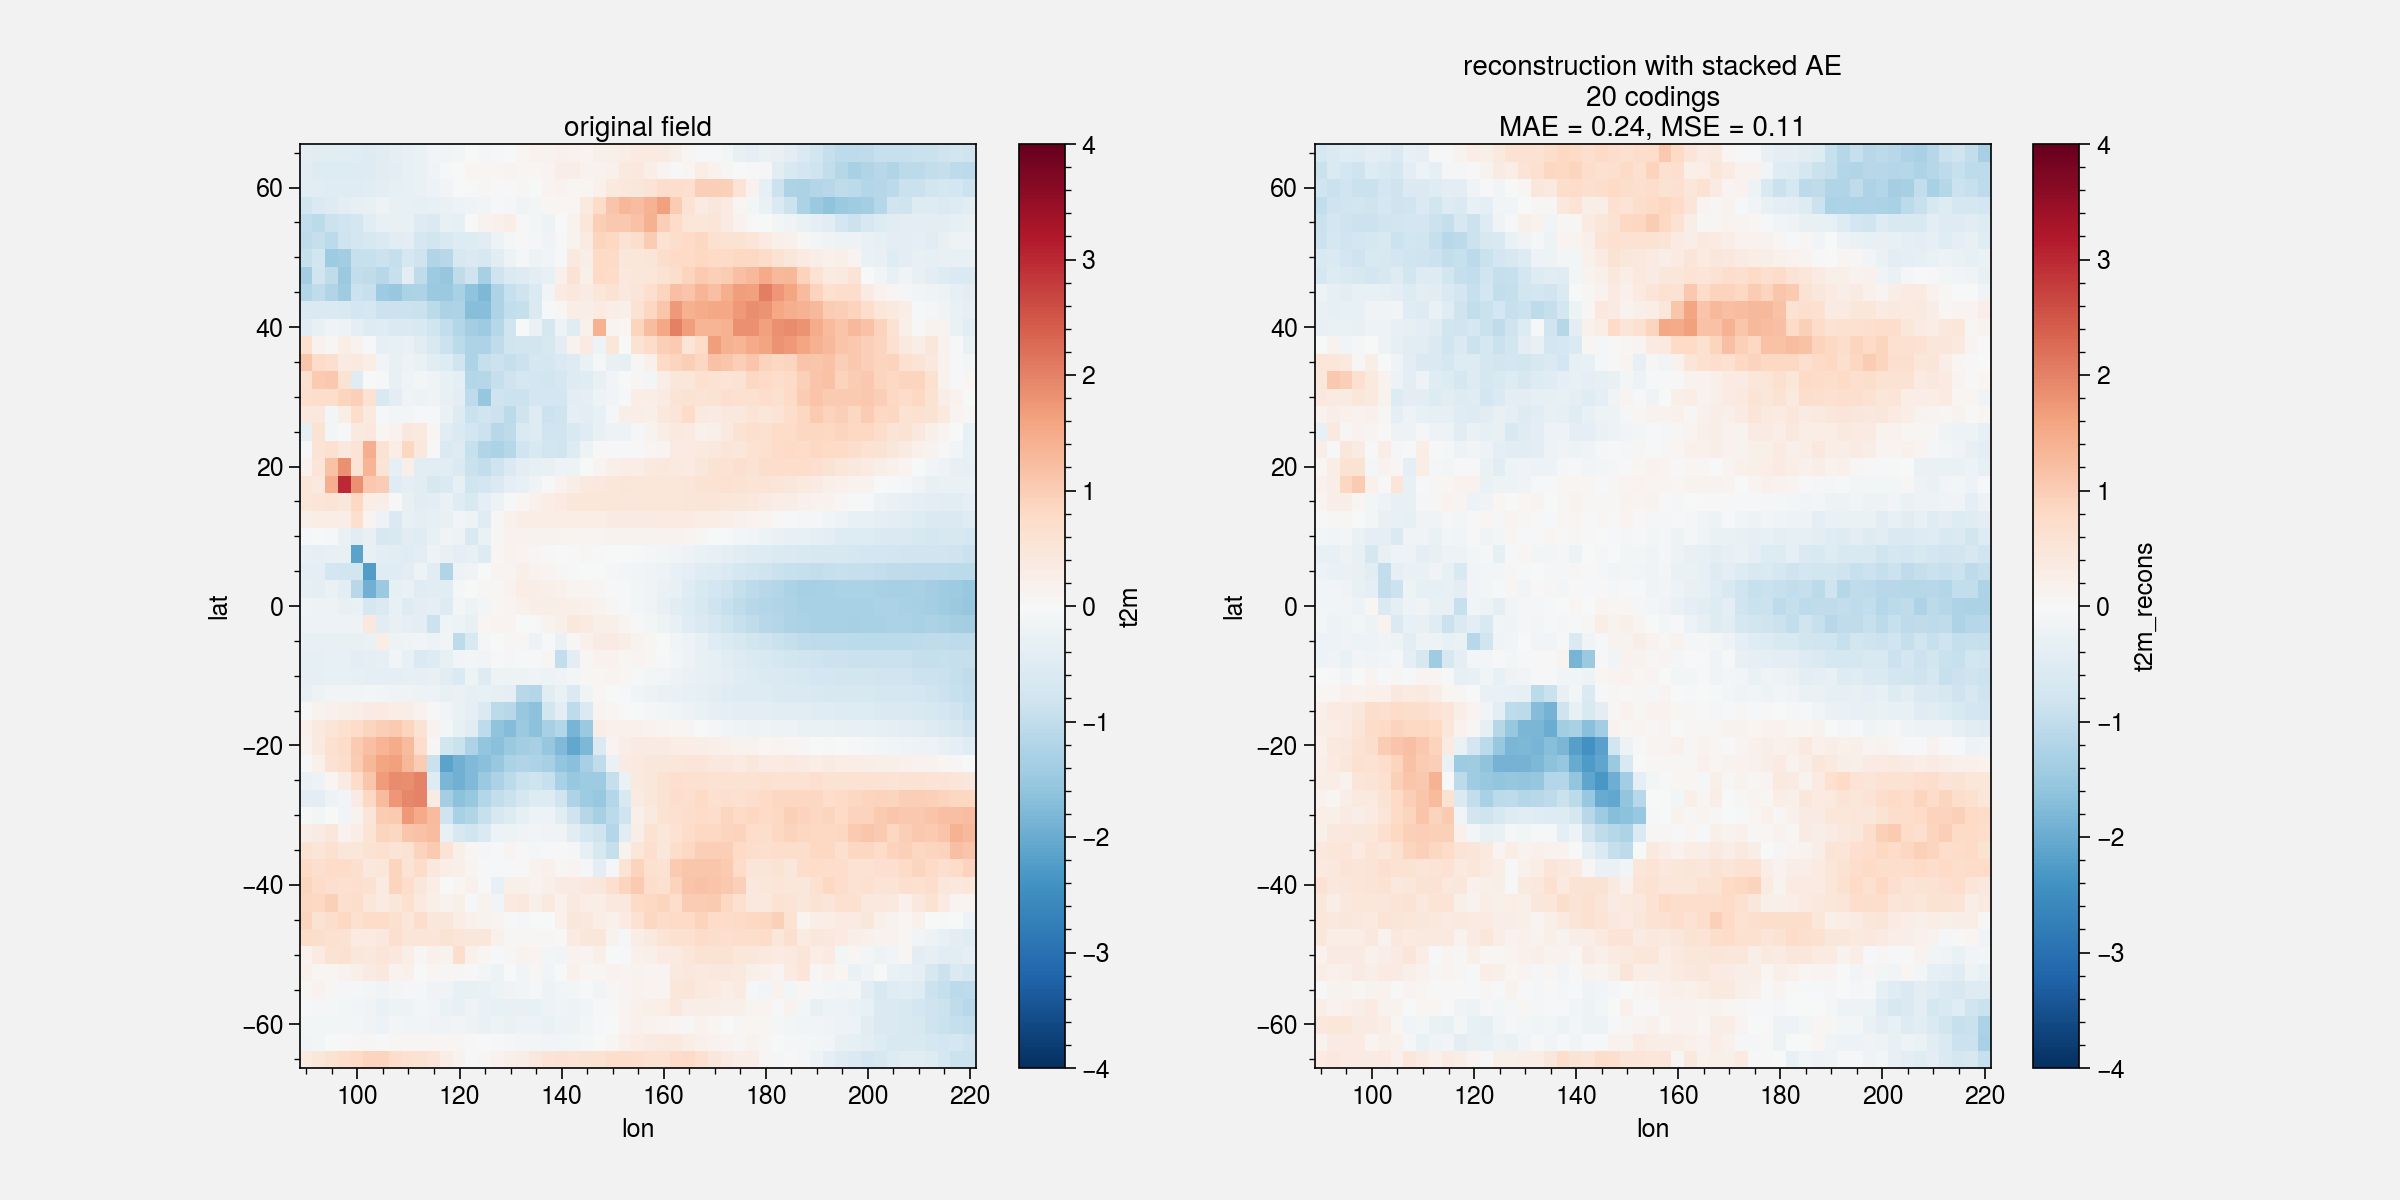

In [56]:
f, axes = plt.subplots(ncols=2, figsize=(12, 6))

dset_valid.isel(time=i)[var_name.lower()].plot(ax=axes[0], vmin=-4, vmax=4, cmap=plt.cm.RdBu_r)

dset_valid.isel(time=i)[var_name.lower() + '_recons'].plot(ax=axes[1], vmin=-4,  vmax=4, cmap=plt.cm.RdBu_r)

axes[0].set_title('original field')

axes[1].set_title(f'reconstruction with stacked AE\n{n_codings} codings\nMAE = {last_mae:4.2f}, MSE = {last_mse:4.2f}')

In [52]:
codings.shape

(72, 20)

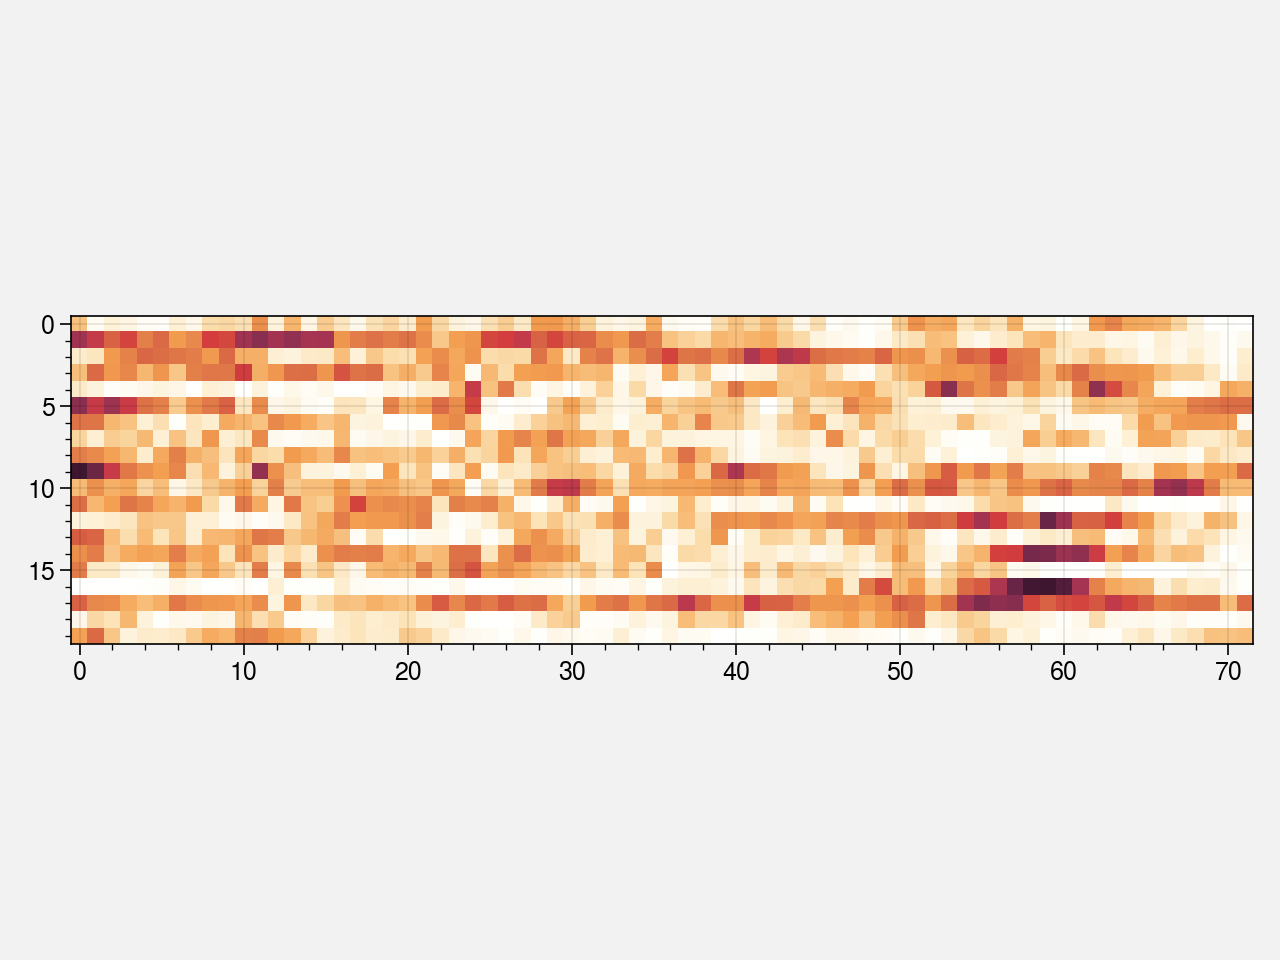

In [53]:
plt.imshow(codings.T)
plt.tight_layout()

### PCA 

In [58]:
from sklearn.decomposition import pca

In [59]:
skpca = pca.PCA()

In [62]:
skpca.fit(X_train.reshape(X_train.shape[0],X_train.shape[1] * X_train.shape[2]))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [61]:
X_train.shape

(216, 53, 53)

In [63]:
PCs = skpca.transform(X_valid.reshape(X_valid.shape[0],X_valid.shape[1] * X_valid.shape[2]))

In [64]:
PCs.shape

(72, 216)

In [68]:
PCs = PCs[:,:n_codings]

In [65]:
EOFs = skpca.components_

In [66]:
EOFs = EOFs[:n_codings,:]

In [72]:
EOFs.shape

(20, 2809)

In [70]:
PCs.shape

(72, 20)

In [74]:
recons_pca = np.dot(PCs, EOFs)

In [76]:
recons_pca.shape

(72, 2809)

In [78]:
recons_pca = recons_pca.reshape(recons_pca.shape[0], ny, nx)

In [79]:
recons_pca.shape

(72, 53, 53)